<center>
    <H1>STAT3007 Deep Learning, Assignment 2</H1>
    <b>2024 Semester 1, due 5pm on 29 Apr</b>
</center>

Please read `instructions.ipynb` first.

**Name**: Henrik Olaussen
<br>
**Student Number**: 48183950

$\newcommand{\reals}{{\mathbf R}}$
$\newcommand{\bfx}{{\mathbf x}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\var}{\text{Var}}$
$\newcommand{\E}{\mathbb{E}}$

## Q1. Optimization (25 marks)

**(a)** (5 marks) In lecture, we introduced the back-propagation algorithm for MLPs and 
mentioned that convolutional neural nets can be viewed as special cases for 
MLPs.
Can the back-propagation formula for MLPs be directly applied to CNNs?
Justify your answer; if your answer is no, also describe what changes are 
needed.

**Answer**.

While training a CNN, we learn the different filters that extract relevant features from the input. These filters are matrices of weights that are updated through back-propagation to minimise the loss. In a CNN, we normally have a set of pooling and convolutional layers before a set of fully connected layers. The fully connected layers takes the information from the convolution-and pooling layers and returnes an output. 

The idea of the backpropagation algortihm is the same in the MLP and the CNN. However, some changes are needed to calculate the gradients using backpropagation for the convolutional- and pooling layers. When applied to the fully connected layers, the backpropagation algorithm is essentially the same as if it was applied to a MLP. Furthermore, when calculating the gradients of the convolutional- and pooling layers, we have to consider the fact that the we have fewer and shared weights between the layers. To compute the correct gradient, one have to rotate the weights. The reason is that in a normal MLP we use matrix multiplication while in a CNN we use convolution, which will change the backward pass. Applying the chain rule will then result in the rotatation of weights. 

**(b)** (5 marks) Let $f(x, y) = \sin(xy) + \cos(x) \cos(y)$.
    Use reverse mode autodiff to compute the value of the partial derivative $\frac{\partial f}{\partial x}$ at $(x, y) = (1, 1)$.
    Show your computational graph, and tabulate the intermediate derivatives.

**Answer**.

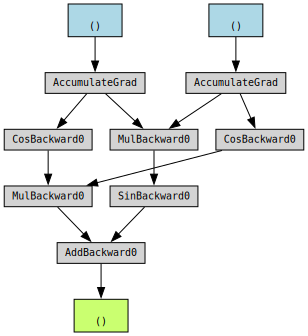

In [224]:
import torch
import torch.nn as nn
from torchviz import make_dot

def f(x,y):
    return torch.sin(x*y) + torch.cos(x)*torch.cos(y)

x = torch.tensor(1.0, requires_grad= True)
y = torch.tensor(1.0, requires_grad= True)

out = f(x,y)
out.backward()
make_dot(out)

**(c)**. (5 marks) Plot the univariate function $f: \mathbf{R} \to \mathbf{R}$ defined by  $f(x) = \tanh(x^3 + 1.5*\sin(3 \pi x))$ over the interval $[-5, 5]$.
Describe two difficulties for minimizing $f$ using gradient descent.

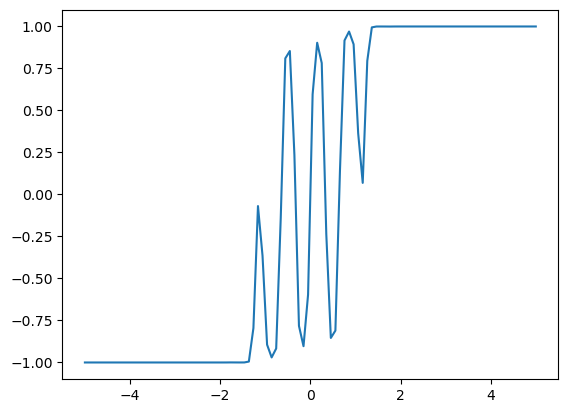

In [225]:
import matplotlib.pyplot as plt

def f(x):
    return torch.tanh(x**3+1.5*torch.sin(3*torch.pi*x))

x = torch.linspace(-5,5,100)

plt.plot(x, f(x))
plt.show()

**Answer.**

The first difficulty is that gradient descent can't guarantee a global solution. This means that saddle points and local minimas are possible solution obtained by gradient descent. Secondly, we have the problem of exploding and vanishing gradients. A vanishing gradient means that the computed gradients are very small in value. As a consequence, gradient descent might converge very slowly towards a solution. Moreover, in the case of an exploding gradient, the gradient is very large in value. This could cause gradient descent to overshoot a possible solution by making excessively large steps in one or more iterations.

**(d)** (10 marks) Let $\alpha > 0$ be a constant, and 
$(x)_{+,\alpha} = \begin{cases} x, & x \ge 0 \\ \alpha x, & x < 0\end{cases}$
denote the leaky ReLU with its slope for the negative part being $\alpha$.

Consider $Z = \sum_{i=1}^{n} (Y_{i})_{+,\alpha} W_{i}$, where $Y_{i}$'s are independent copies of a random variable $Y$ symmetrically distributed around 0, and $W_{i}$'s are independent copies of the random variable $W \sim N(0, \sigma^{2})$.

Find $\sigma^{2}$ such that $\var(Z) = \var(Y)$. You can use results covered in lectures and the prerequisite courses. All other steps must be justified.

**Answer.**

Assuming $Y$ and $W$ are independent we get:

$$
\text{var}(Z) = \text{var}(\sum_{i=1}^n(Y_i)_{+, \alpha}W_i) =  \left\{\begin{matrix}
\sum_{i=1}^n \text{var}(Y_iW_i) &, Y_i \geq 0 \\
\sum_{i=1}^n \text{var}(\alpha Y_iW_i) &, Y_i < 0 \\
\end{matrix}\right. 
$$

First, we consider the case $Y_i \geq 0$:

$$
\text{var}(Y_iW_i) = E[Y_i^2W_i^2] - E[Y_iW_i]^2 = E[Y_i^2]E[W_i^2] - E[Y_i]^2E[W_i]^2 \\
= (\text{var}(Y_i)+E[Y_i]^2)(\text{var}(W_i)+E[W_i]^2)-E[Y_i]^2E[W_i]^2
$$

We know that $E[Y_i] = E[W_i] = 0$ and $\text{var}(W_i) = \sigma^2$:

$$
(\text{var}(Y_i)+E[Y_i]^2)(\text{var}(W_i)+E[W_i]^2)-E[Y_i]^2E[W_i]^2 = \text{var}(Y_i)\sigma^2 \\

\implies \text{var}(Z) = \sum_{i=1}^n \text{var}(Y_i)\sigma^2 = n\sigma^2\text{var}(Y)
$$

By following the same procedure for the case $Y_i < 0$, we get:

$$
\text{var}(Z) = \sum_{i=1}^n \text{var}(Y_i)\sigma^2 \alpha^2 = \alpha^2 n\sigma^2\text{var}(Y)
$$

Consequently, $\text{var}(Z) = \text{var}(Y)$ only if $\alpha = 1$ and $\sigma^2  = \frac{1}{n}$.

## Q2. Fashion Networks (45 marks)

We implement several neural network models for the FashionMNIST dataset in this question. The dataset contains a collection of Zalando's article images. The code below loads the FashionMNIST dataset and shows some of the images.

torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


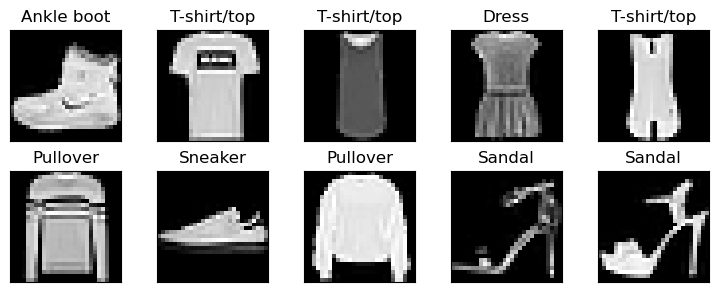

In [226]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Lambda
from util import *
        
# if you don't have FashionMNIST downloaded, run the code below twice to get rid of verbose outputs
fashion_tr = torchvision.datasets.FashionMNIST('/Users/henrikolaussen/Desktop/UQ/vår/Deep Learning/Assignments /A2/data', train=True, download=True)
fashion_ts = torchvision.datasets.FashionMNIST('/Users/henrikolaussen/Desktop/UQ/vår/Deep Learning/Assignments /A2/data', train=False, download=True)

# input values are normalized to [0, 1]
x_tr, y_tr = fashion_tr.data.float()/255, fashion_tr.targets
x_ts, y_ts = fashion_ts.data.float()/255, fashion_ts.targets

print(x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape)

classes = fashion_tr.classes

plot_gallery([x_tr[i] for i in range(10)], 
             titles=[classes[y_tr[i]] for i in range(10)],
             xscale=1.5, yscale=1.5, nrow=2)

### Logistic Regression (0 marks)

**(a)** As a baseline, the following code trains a logistic regression model on the training set and report its accuracies on both the training and test sets.

In [227]:
from sklearn.linear_model import LogisticRegression

def vec(x):
    return x.reshape(x.shape[0], -1)

lr = LogisticRegression(max_iter=200)
lr.fit(vec(x_tr), y_tr)

print('Accuracy: train/test = %.3f / %.3f' % (lr.score(vec(x_tr), y_tr), lr.score(vec(x_ts), y_ts)))

/Users/henrikolaussen/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: train/test = 0.873 / 0.843


### Multilayer Perceptrons (20 marks)

For training an MLP, we flatten each image to a vector, and convert the labels to their one-hot encodings.

In [228]:
from sklearn.model_selection import train_test_split
from torch.nn.functional import one_hot

def vec(x):
    return x.reshape(x.shape[0], -1)

x_tr_mlp, y_tr_mlp = vec(x_tr), one_hot(y_tr)
x_ts_mlp, y_ts_mlp = vec(x_ts), one_hot(y_ts)

**(b)** (5 marks) We considering training a two-hidden-layer MLP with 50 ReLU units for each hidden layer, and 10 output units:

\begin{align*}
    f(\mathbf{x}; W_{1}, W_{2}, W_{3}, b_{1}, b_{2}, b_{3}) 
    = 
    \text{softmax}(W_{3} g(W_{2} g(W_{1} \mathbf{x} + b_{1}) + b_{2}) + b_{3}),
\end{align*}

where each 
$\mathbf{x} \in \mathbf{R}^{d}$ is the vector representation of a digit image, 
$W_{1} \in \reals^{50 \times d}$,
$W_{2} \in \reals^{25 \times 50}$,
$W_{3} \in \reals^{10 \times 25}$ are the weight matrices, 
$b_{1} \in \reals^{50}, b_{2} \in \reals^{25}$ and $b_{3} \in \reals^{10}$ are the biases, and 
$g$ is ReLU.
Complete the code below according to the docstring to implement this two-hidden-layer MLP. 

**Answer**.

In [229]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FashionMLP(nn.Module):
    def __init__(self, init='rand'):
        '''
        Initialize neural network parameters.
        
        Parameters
        ----------
        init: either 'zero' (all parameters are 0) or 'rand' (each parameter is uniformly sampled from [-0.5, 0.5])
        '''
        super().__init__()
        
        d = 28*28

        # Task: add your initialization code below. You may want to use nn.Parameter. For example, 
        #   self.W = nn.Parameter(torch.randn(100, 10)) 
        # makes the parameters accessible via self.parameters()
        if init == 'zero': # all parameters initialised to 0
            self.W1 = nn.Parameter(torch.zeros(50,d))
            self.W2 = nn.Parameter(torch.zeros(25,50))
            self.W3 = nn.Parameter(torch.zeros(10,25))
            self.b1 = nn.Parameter(torch.zeros(50)) 
            self.b2 = nn.Parameter(torch.zeros(25)) 
            self.b3 = nn.Parameter(torch.zeros(10))

        elif init == 'rand': # all parameters randomly drawn from N(0, 0.1^2) 
            self.W1 = nn.Parameter(torch.randn(50,d)*0.1)
            self.W2 = nn.Parameter(torch.randn(25,50)*0.1)
            self.W3 = nn.Parameter(torch.randn(10,25)*0.1)
            self.b1 = nn.Parameter(torch.randn(50)*0.1)
            self.b2 = nn.Parameter(torch.randn(25)*0.1)
            self.b3 = nn.Parameter(torch.randn(10)*0.1)
        else:
            raise BaseException('Unsupported weight initialization method!')
    
    def forward(self, x):
        '''
        Compute the outputs for given inputs.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        
        Returns
        -------
        o: a tensor of shape (n_samples, 10) containing the class scores
        '''
        # Task: add your forward computation code below
        layer1 = F.relu(torch.matmul(x, self.W1.t())+self.b1)
        layer2 = F.relu(torch.matmul(layer1, self.W2.t())+self.b2) 
        return F.softmax(torch.matmul(layer2, self.W3.t()) + self.b3, dim=1)
    
    def predict(self, x):
        '''
        Predict the class indices for the input examples.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        
        Returns
        -------
        l: a tensor of shape (n_samples,) consisting of class indices
        '''
        o = self(x) # the same as self.forward(x)
        l = torch.max(o, 1)[1]
        return l
            
    def score(self, x, y):
        '''
        Compute the model's accuracy on the given dataset.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        y: a tensor of shape (n_samples, 10) containing the one-hot encodings
        '''
        pred_cls = self.predict(x)
        true_cls = torch.max(y, 1)[1]
        return (pred_cls == true_cls).sum().float().item() / len(y)

**(c)** (15 marks)
We study the effect of initialization, learning rates, and batch sizes when training the above MLP by minimizing the following quadratic loss
\begin{align*}
  R_{n}({\bf w})
  = \frac{1}{n} \sum_{i=1}^{n} ||f(\mathbf{x}_{i}; {\bf w}) - y_{i}||_{2}^{2},
\end{align*}
where $f({\bf x}, {\bf w})$ is the MLP with ${\bf w}$ as the parameters and ${\bf x}$ as the input, and
$(\mathbf{x}_{1}, y_{1}), \ldots (\mathbf{x}_{n}, y_{n}) \in \mathbf{R}^{d} \times
\mathbf{R}^{10}$ is the training set

Train the MLP by running SGD for 100 epochs (one epoch means one pass through the training data) using all combinations of the following hyperparameter values:
* initializaton: `zero`, `rand`
* learning rate: 0.001, 0.01, 0.1,  1
* batch size: 100, 60000

Compute the training and test accuracies for all these 16 models, and comment on the effect of initialization, learning rate and batch size.
Write your code by completing the partial code provided below. The generic `train` and `test` functions can be used for training CNNs later.

**Answer**.

In [230]:
def mseloss(o, y):
    '''
    Compute the MSE loss defined in the question.
    
    Parameters
    ----------
    o: a tensor of shape (n_samples, 10) containing the class scores
    y: a tensor of shape (n_samples, 10) containing the one-hot encodings
    
    Returns
    -------
    l: the MSE loss
    '''
    # Task:  compute the loss - make sure your code computes exactly the required loss
    l = torch.mean((o-y)**2)
    return l

In [231]:
from util import *

def train(net, x, y, lossfunc, lr=0.1, momentum=0, batch_size=600, nepochs=10):
    device = next(net.parameters()).device # check what device the net parameters are on
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x, y), batch_size=batch_size, shuffle=True)
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        # Task: fill in your training code below and compute epoch_loss (the average loss on all batches in an epoch)
        epoch_loss = 0
        n_batches = 0 
    
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            optimizer.zero_grad()
            o_batch = net.forward(x_batch)

            l = lossfunc(o_batch, y_batch)

            l.backward()
            optimizer.step()

            epoch_loss += l.item()
            n_batches += 1
         
        epoch_loss /= n_batches

        # evaluate network performance
        acc = test(net, x, y, batch_size=batch_size)

        # show training progress
        loop.set_postfix(loss="%5.5f" % (epoch_loss),
                         train_acc="%.2f%%" % (100*acc))
        
       

# try running test(FashionMLP(), x_ts_mlp, y_ts_mlp, showerrors=True) to see what the code does
def test(net, x, y, batch_size=600, showerrors=False):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = next(net.parameters()).device

        pred_cls = []
        # make predictions on mini-batches  
        dataloader = DataLoader(DatasetWrapper(x), batch_size=batch_size, shuffle=False)
        for x_batch in dataloader:
            x_batch = x_batch.to(device)
            pred_cls.append(torch.max(net(x_batch), 1)[1].cpu())

        # compute accuracy
        pred_cls = torch.cat(pred_cls) # concat predictions on the mini-batches
        true_cls = torch.max(y, 1)[1].cpu()
        acc = (pred_cls == true_cls).sum().float() / len(y)

        # show errors if required
        if showerrors:
            idx_errors = (pred_cls != true_cls)

            x_errors = x[idx_errors][:10].cpu()
            y_pred = pred_cls[idx_errors][:10].cpu().numpy()
            y_true = true_cls[idx_errors][:10].cpu().numpy()

            plot_gallery(x_errors.squeeze(),
                         titles=[classes[y_true[i]] + '\n->' + classes[y_pred[i]] for i in range(10)],
                         xscale=1.5, yscale=1.5, nrow=2)

        return acc        

In [233]:
torch.manual_seed(1)
import pandas as pd

# Task: write your code to train the 16 models and compute their training and test accuracies

initializations = ['zero','rand']
learning_rates = [0.001, 0.01, 0.1,  1]
batch_sizes = [100, 60000]

for init in initializations:
    for lr in learning_rates:
        for bs in batch_sizes:
            net = FashionMLP(init=init)
            print(f'Initialisation: {init}, learning rate: {lr}, batch size: {bs}')
            train(net, x_tr_mlp, y_tr_mlp, lossfunc = mseloss, lr=lr, batch_size=bs, nepochs=10)
            print(f'Test accuracy: {test(net, x_ts_mlp, y_ts_mlp, batch_size=bs)*100}%')
            print('------------')
           

Initialisation: zero, learning rate: 0.001, batch size: 100


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 0.001, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 0.01, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 0.01, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 0.1, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 0.1, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 1, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: zero, learning rate: 1, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it, loss=0.09000, train_acc=10.00%]


Test accuracy: 10.0%
------------
Initialisation: rand, learning rate: 0.001, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it, loss=0.08992, train_acc=13.20%]


Test accuracy: 13.079998970031738%
------------
Initialisation: rand, learning rate: 0.001, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it, loss=0.09013, train_acc=14.23%]


Test accuracy: 14.319999694824219%
------------
Initialisation: rand, learning rate: 0.01, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it, loss=0.08494, train_acc=31.13%]


Test accuracy: 30.40999984741211%
------------
Initialisation: rand, learning rate: 0.01, batch size: 60000


100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it, loss=0.09041, train_acc=8.17%]


Test accuracy: 8.010000228881836%
------------
Initialisation: rand, learning rate: 0.1, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it, loss=0.03003, train_acc=79.75%]


Test accuracy: 78.3499984741211%
------------
Initialisation: rand, learning rate: 0.1, batch size: 60000


100%|██████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it, loss=0.09078, train_acc=5.25%]


Test accuracy: 5.53000020980835%
------------
Initialisation: rand, learning rate: 1, batch size: 100


100%|█████████████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it, loss=0.01874, train_acc=87.66%]


Test accuracy: 85.6199951171875%
------------
Initialisation: rand, learning rate: 1, batch size: 60000


100%|█████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it, loss=0.08989, train_acc=16.10%]

Test accuracy: 16.040000915527344%
------------


I did not have the timet to do 100 nepochs, as this would have taken my computer 40 minutes. However, one can see from above that with the zero initialisation, we do not get good results. As soon as we apply the random initialisation, we start getting betteer results for some combinations. Also, we see that the batch size has an effect, as a too big batch size does not give a good solution. This however, might be a result by not using enough epochs. With a smaller batch size, we get better results. One can also see that a learning rate too small combined with a large batch size gives bad results. This makes sense, as we do fewer optimisation steps in additon to each step being relatively small. The best train and test error is obtained in the model with leanring rate 1 and batch size 100. 

### Convolution neural networks (25 marks)

For training a CNN, we use one-hot encodings of the labels as for the MLP, but we add a channel dimension to the data using the `unsqueeze` function, which will be convenient for performing convolutions.

In [ ]:
x_tr_cnn, y_tr_cnn = x_tr.unsqueeze(1), one_hot(y_tr)
x_ts_cnn, y_ts_cnn = x_ts.unsqueeze(1), one_hot(y_ts)

**(d)** (5 marks) Consider the following CNN:
The input layer is followed by the following layers:
a convolutional layer with 64 3x3 filters (stride 1) and sigmoid activation,
a 2x2 average pooling layer,
a fully connected layer with 50 neurons and sigmoid activation,
and finally, a fully connected output layer with 10 neurons and identity activation.
Complete the code below to implement your CNN in PyTorch.
Pytorch's nn.Sequential and nn.Conv2d are helpful.

**Answer**.

In [ ]:
import torch.nn as nn
    
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        # Task: write your class initialization code below
        # implement your CNN such that it is easy to extract features for answering (f)
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,kernel_size=3,stride=1),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2),
        )

        self.dense_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64 * 13 * 13, out_features = 50), #64 channels of 14x14 images 
            nn.Sigmoid()
        )

        self.output = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        # Task: write your forward computation code below
        x = self.cnn_layers(x)
        self.features =  self.dense_layer(x) #the extracted features 
        out = self.output(self.features) #compute output of the fully connected layers 
        return out

**(e)** (5 marks)
Train a FashionCNN. Use an appropriate loss function and appropriate hyperparameters (e.g., the learning rate, the number of epochs, the batch size).
Briefly describe how you make these decisions.
Report the test set accuracy of your final CNN and display 10 of its errors on the test set using the `test` function provided above.

**Answer**.

In [ ]:
def CELoss(o, y): #Cross Entropy Loss

    class_prob = torch.softmax(o, dim=1)
    temp = -torch.sum(torch.log(class_prob) * y, dim=1)
    
    # Compute the average loss across the batch
    loss = torch.mean(temp)
    return loss

I have chosen the learning rate of 0.1, batch_size of 50 and nepochs of 5. I decided all of these through trial and error. Firstly, the learning rate should not be either too small or too big. Too small value will result in slow convergence, and a too big value might overshoot the actual solution. With the batch size of 50, I noticed that I only needed 5 epochs to get past 80% accuracy on both training and test set. 

In [ ]:
lr = 0.1
bs = 50
nepochs = 5

netCNN = FashionCNN()
train(netCNN, x_tr_cnn, y_tr_cnn, lossfunc=CELoss, lr = lr, batch_size=bs, nepochs=nepochs)
print(f'Test accuracy: {test(netCNN, x_ts_cnn, y_ts_cnn, batch_size=bs)*100}%')

100%|███████████████████████████████████████████| 5/5 [02:39<00:00, 31.89s/it, loss=0.47353, train_acc=82.35%]


Test accuracy: 80.94999694824219%


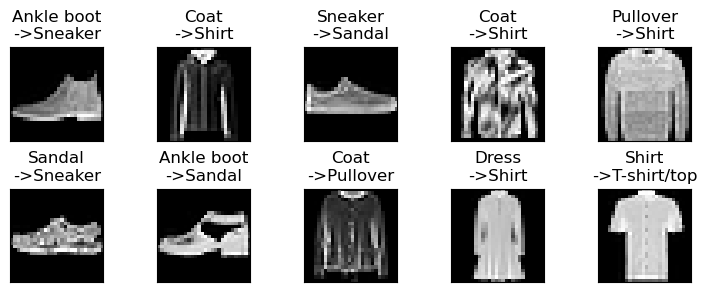

tensor(0.8095)

In [ ]:
#display 10 of the errors made when testing
test(netCNN, x_ts_cnn, y_ts_cnn, batch_size=bs, showerrors=True)

**(f)** (10 marks)
For the second test image, retrieve its nearest 5 training examples in the
learned feature space (the learned features are the inputs to the output
layer, that is, the output values of the last hidden layer) for the final model in (e).
Do they represent the same kind of clothes as the test image? 
You can use any suitable distance measure to answer this question.

**Answer**.

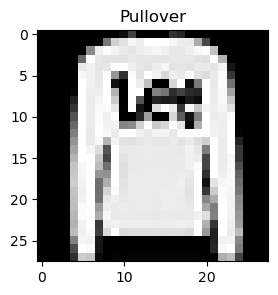

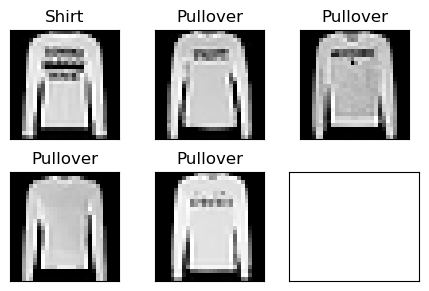

In [ ]:
test_im = x_ts_cnn[1].unsqueeze(1)
test_lab = y_ts_cnn[1]

#extract learned features of second test image
test_out = netCNN.forward(test_im)
test_features = netCNN.features

#extract features of training images
train_out = netCNN.forward(x_tr_cnn)
train_features = netCNN.features

#find the 5 closest 
d = torch.sum((train_features-test_features)**2, axis=1) #second norm squared
ind = torch.argsort(d)[:5]
nearest_5 = x_tr[ind] 
nearest_5_lab = y_tr[ind] #labels of nearest 5

#display test image
plt.figure(figsize=(3,3))
plt.title(fashion_tr.classes[torch.argmax(test_lab)])
plt.imshow(test_im[0][0], cmap='gray', )

#display 5 closest training images
plot_gallery([nearest_5[i] for i in range(5)], 
             titles=[classes[nearest_5_lab[i]] for i in range(5)],
             xscale=1.5, yscale=1.5, nrow=2)

We see that we mostly get pullovers, and all the clothes are very similar. The shirt from the training set looks very similar to the test example, so the fact that the distance between them in the feature space is low makes sense.  

**(g)** (5 marks) Use PCA to project the learned test set feature vectors in (e) to a 2D space.
Generate the scatter plot of these 2D projections and color points for different classes using different colors.

**Answer.**

In [ ]:
from sklearn.decomposition import PCA

test_output = netCNN.forward(x_ts_cnn)

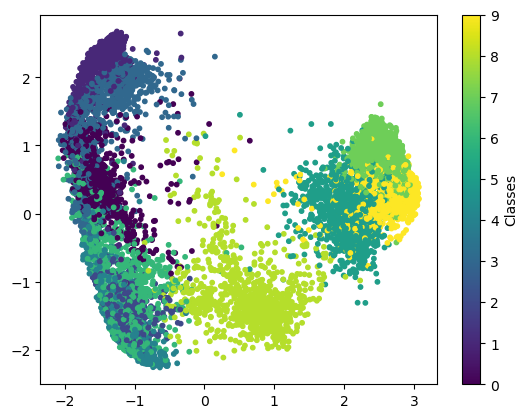

In [ ]:
pred_cls = []
pca_trans = torch.zeros(10000,2)

pred_cls.append(torch.max(test_output, 1)[1])

features = netCNN.features.detach().numpy()
pca = PCA(n_components=2)

projections = pca.fit_transform(features)

scatter = plt.scatter(projections[:,0], projections[:,1], c = pred_cls[0], s = 10)
plt.colorbar(scatter, label = 'Classes')
plt.show()

## Q3. Translating a cryptic language (30 marks)
In a fictitious world, a group of scientists obtained a document containing a sample of texts written in a cryptic language, together with their English translations. However, they are unable to find a way of translating arbitrary texts from the cryptic language. Knowing that you have learned deep learning models for machine translation, they are approaching you for help.

They have sent you a data file containing a training set and a test set.
The code below illustrates how to use the data.

In [ ]:
import pickle as pkl

data = pkl.load(open('cryptic.pkl', 'rb'))
x_tr = data['train']['x']
y_tr = data['train']['y']
x_ts = data['test']['x']
y_ts = data['test']['y']
print('%d training pairs and %d test pairs\n' % (len(x_tr), len(x_ts)))

print('The third pair of training example:')
print('- Cryptic:', x_tr[2])
print('- English:', y_tr[2])

29721 training pairs and 9431 test pairs

The third pair of training example:
- Cryptic: T:aTmUB:BTzp:;)p,:Gp,M 1iU773g rvz:Um:7;,7o,pM r:B
- English: a panic came over her. "Kitty! I'm in torture. I c


As you can see, these texts are not necessarily complete sentences, and in fact, some words may be incomplete too.

In this question, you will train a character-level machine translator using the encoder-decoder architecture as described in Lecture 18 - that is, the encoder takes in one letter at a time from the text in the cryptic language, and the decoder generates one letter at a time for its English translation.
For this dataset, each short text, whether in the cryptic language or in English, has exactly 50 letters, which is convenient for batching processing using recurrent models.

Specifically, as described in lecture, the encoder-decoder architecture has an encoder RNN $f^{e}$, a decoder RNN $f^{d}$, and a predictor $g$: 
\begin{align*}
    h^{e}_{t} &= f^{e}(h_{t-1}^{e}, x_{t}), \\
    h^{d}_{t} &= f^{d}(h_{t}^{d}, y_{t-1}, c), \\
    y_{t} &\sim g(\cdot | h_{t}^{d}, y_{t-1}, c).
\end{align*}
For this problem, each input $x_{t}$ is the one-hot vector for a single letter in the cryptic text,
each output $y_{t}$ is the one-hot vector for a single letter in the English text.
As in general, the context vector $c$ is the last hidden state from the encoder, 
and the input to the decoder at the $t$-th time step is $(y_{t-1}, c)$.
The decoder RNN behaves different during training and testing:
* During training, each $y_{t-1}$ in the input $(y_{t-1}, c)$ to the decoder is the one-hot vector representing the $(t-1)$-th letter in the given English translation (assume $t=1$ is the first letter), except that $y_{0}$ is a one-hot vector representing a special SOS (start of sentence) letter.
* During testing, each $y_{t-1}$ in the input $(y_{t-1}, c)$ to the decoder is obtained in a greedy way as the one-hot vector for the most likely letter predicted by the predictor $g$, except that $y_{0}$ represents SOS.

**(a)** (5 marks)
Complet the code for the `Lang` class below.
Append an EOS letter '\n' to each example cryptic/English text.
Create `Lang` objects for both the cryptic language and English, and use them to convert texts to one-hot representations for both the training and test data.
Make sure you add an additional SOS letter defined by `chr(0)` as an additional letter for the English language, as this is needed for the decoder.

**Answer**.

In [ ]:
import torch

class Lang:
    def __init__(self, text):
        self.int2char = dict(enumerate(sorted(set(text))))
        self.char2int = {v: k for k, v in self.int2char.items()}
        self.num_char = len(self.char2int)

    def onehot(self, texts):
        '''
        Convert a list of strings to a list of sequences of one-hot vectors for letters.
        
        Parameters
        ----------
        texts: a list or array of str

        Returns
        -------
        outputs: a list, where output[i] is a list of one-hot vectors for the letters in texts[i]
        '''
        # Task: implement this function according to the docstring
        n = len(texts)
        output = torch.zeros((n, 51, self.num_char), dtype = int) #[which text, letters in the sentence, number of char in language]
        for i in range(n):
            sentence = texts[i]
            inds = torch.zeros(51, dtype=int)
            for j in range(51): 
                char = sentence[j]
                inds[j] = self.char2int[char]
            output[i] = one_hot(inds, num_classes=self.num_char)  
        return output


    def text(self, onehots):
        '''
        Convert a list of sequences of one-hot vectors to a list of strings.
        
        Parameters
        ----------
        onehots: a list, where onehots[i] is a list of one-hot vectors

        Returns
        -------
        outputs: a list, where output[i] is a str corresponding to sequence of one-hot vectors in onehots[i]
        '''
        # Task: implement this function according to the docstring
        n = len(onehots) #number of sentences 
        output = []
        for i in range(n):
            string = ''
            for j in range(51):
                string += self.int2char[int(torch.argmax(onehots[i][j]))]
            output.append(string)
        return output

# Task: create the Lang objects for the cryptic language and English, and convert the data to one-hot representations
SOS = chr(0)
EOS = '\n'

#Add EOS
x_tr, y_tr = [string + EOS for string in x_tr], [string + EOS for string in y_tr]
x_ts, y_ts = [string + EOS for string in x_ts], [string + EOS for string in y_ts]

cr = Lang(''.join(x_tr))
en = Lang(''.join([SOS] + y_tr)) 

In [ ]:
en.num_char, en.char2int, en.int2char

(78,
 {'\x00': 0,
  '\n': 1,
  ' ': 2,
  '!': 3,
  '"': 4,
  "'": 5,
  '(': 6,
  ')': 7,
  ',': 8,
  '-': 9,
  '.': 10,
  '0': 11,
  '1': 12,
  '2': 13,
  '3': 14,
  '4': 15,
  '5': 16,
  '6': 17,
  '7': 18,
  '8': 19,
  '9': 20,
  ':': 21,
  ';': 22,
  '?': 23,
  'A': 24,
  'B': 25,
  'C': 26,
  'D': 27,
  'E': 28,
  'F': 29,
  'G': 30,
  'H': 31,
  'I': 32,
  'J': 33,
  'K': 34,
  'L': 35,
  'M': 36,
  'N': 37,
  'O': 38,
  'P': 39,
  'Q': 40,
  'R': 41,
  'S': 42,
  'T': 43,
  'U': 44,
  'V': 45,
  'W': 46,
  'X': 47,
  'Y': 48,
  'Z': 49,
  '_': 50,
  '`': 51,
  'a': 52,
  'b': 53,
  'c': 54,
  'd': 55,
  'e': 56,
  'f': 57,
  'g': 58,
  'h': 59,
  'i': 60,
  'j': 61,
  'k': 62,
  'l': 63,
  'm': 64,
  'n': 65,
  'o': 66,
  'p': 67,
  'q': 68,
  'r': 69,
  's': 70,
  't': 71,
  'u': 72,
  'v': 73,
  'w': 74,
  'x': 75,
  'y': 76,
  'z': 77},
 {0: '\x00',
  1: '\n',
  2: ' ',
  3: '!',
  4: '"',
  5: "'",
  6: '(',
  7: ')',
  8: ',',
  9: '-',
  10: '.',
  11: '0',
  12: '1',
  13:

In [ ]:
cr.text(cr.onehot(x_tr[:10])) == x_tr[:10], en.text(en.onehot(y_tr[:10])) == y_tr[:10]

(True, True)

In [ ]:
#Add SOS 
#y_tr, y_ts = [SOS + string for string in y_tr], [SOS + string for string in y_ts]

#Make one hots:
x_tr_oh, y_tr_oh = cr.onehot(x_tr), en.onehot(y_tr)
x_ts_oh, y_ts_oh = cr.onehot(x_ts), en.onehot(y_ts)

**(b)** (10 marks)
Complete the code for the encoder-decoder model below.
Write a short paragraph to briefly describe the type of architecture used
(e.g. vanilla RNN, LSTM, GRU, MLP) for the encoder/decoder/predictor, and the hyperparameters chosen 
(e.g. number of layers, number of neurons for each layer, activation functions).

**Answer**.

I have used an architecture with a LSTM as decoder and encoder. Firstly, the encoder-LSTM is fed with examples from the cryptic language. The Encoder then produces a context vector which is then fed to the decoder-LSTM. Each hidden state contains a number of hidden features (x dimentions in each hidden state) (I have chosen 10), which is used to calculate the ouput from that hidden state, and is then fed to the next hidden state. Lastly, the output from the decoder is fed through a dense layer, which produces a basis for predicting what the correct english letter is. The dense layer has just a linear activiation. When testing, the class probabilities are returned.

I was not able to finish the code below, but I have tried to implement it. 

In [ ]:
import torch.nn as nn
from torch.nn import LSTM
import numpy as np
torch.manual_seed(1)
np.random.seed(1)

class Translator(nn.Module):
    '''
    Your code should support usages as illustrated in the code below, and you should run such 
    code to see if your model has any bug before proceeding to train it.
    
    net = Translator(en, cr)
    # input the one-hot representation of some cryptic texts and their translations, and output
    # the class probabilities at each time step.
    p = net(x, y)
    # input the one-hot representation of some cryptic texts, and output one-hot representation
    # of their translations
    yhat = net(x)
    '''
    
    def __init__(self, en: Lang, cr: Lang, hidden_size):
        '''
        You can add additional arguments to this function if you want.
        '''
        super(Translator, self).__init__()
        self.en = en
        self.cr = cr
        # Task: define your encoder RNN, decoder RNN and the predictor by modifying the code below
        self.hidden_size = hidden_size
        self.encoder = LSTM(input_size=cr.num_char, hidden_size=hidden_size, batch_first=True) #hidden size: features in each hidden state
        self.decoder = LSTM(input_size=en.num_char, hidden_size=hidden_size, batch_first=True) #Input here is the context vector from encoder
        self.predictor = nn.Linear(hidden_size, en.num_char) 

    def forward(self, x: torch.tensor, y: torch.tensor = None):
        '''
        Compute the class/letter distribution during training and one-hot vectors during testing.
        Note that while in general, we stop generating the text only when EOS is generated, we 
        always generate output sequences of the same lengths as the input sequences for simplicity
        in this question.

        Parameters
        ----------
        x: a batch_size x length x num_char_cr one-hot tensor representation for batch_size input 
           texts, each of the same length, and where num_char_cr is the number of letters in the
           cryptic language
        y: None during testing, and a batch_size x length x num_char_en tensor during training, 
           corresponding to the one-hot representation for the English translation of the cryptic 
           texts.

        Returns:
        output: a batch_size x length x num_char_en tensor, which represents the class probabilities 
           output by the predictor g during training, and the one-hot representation of the English 
           translation of the texts using the greedy strategy described in class.
        '''
        # Task: implement this function according to the docstring
        # Note: reversing the input sequence before feeding it to the encoder is often helpful

        output = torch.zeros(x.size()[0], x.size()[1], en.num_char)#.to(device)
        batch_size = x.size()[0]
        seq_size = x.size()[1]

        x = x.float()
        _, (context, cell) = self.encoder(x) #context vector is the final hidden state 


        y_0 = one_hot(torch.tensor(0), num_classes=en.num_char) #SOS 
        context = context.repeat(en.num_char, 1) # want to use context x as input in each hidden state 
        

        if y != None: #training 
            out, (hidden,cell) = self.decoder(y.float(), context)
            out = self.predictor(out)
            return out

        preds = torch.zeros(batch_size, seq_size, en.num_char) #y_(t-1)

        for t in range(1,51): #iteratively predict every letter in each test example using the prediction y_(t-1) as input in h_t
            out, _ = self.decoder(prev_pred, context)

            out = self.predictor(out)
            class_prob = F.softmax(out) #class probabilities 
            pred_ind = torch.argmax(class_prob, dim = 1) 
            
            #update -> not correct, could not finish
            prev_pred = one_hot(pred_ind, num_classes=en.num_char)
            preds[:,t,:] = prev_pred
            output[:,t,:] = class_prob

        return output
            

    def translate(self, x: list[str]):
        '''
        Return a list of English texts of a list of cryptic texts.
        '''
        x = self.cr.onehot(x)
        y = self(x)
        y = self.en.text(y)
        return y

In [ ]:
net = Translator(en, cr, hidden_size=10)
o1 = net(x_tr_oh[:10]) # assume x_tr_oh is the onehot tensor verson of x_tr
o2 = net(x_tr_oh[:10], y_tr_oh[:10]) # assume y_tr_oh is the onehot tensor version of y_tr

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

**(c)** (15 marks)
Implement a train function and train your model.
Describe details in the training procedure so that someone reading your
report are able to reproduce how you train the model.
That is, you need to include details like the choice of optimizer together
with the hyperparameters used, the batch size, the initial hidden state.

For your final model, output its translations along with the given translations for the first three test examples.
In addition, use the `jaccard` function to score your model's translations on the training and test sets.
5 marks are allocated for your model performance: your model receives $5 \times \min(1, \text{test score}/0.85)$ marks.
Note that training a good model can take time, and it is better to figure out how to train a good model on a small subset first before trying to train a good model on the full dataset.

Save your final model using `torch.save` in the `supplements` and name your model as `mt.pt`.

**Answer**.

In [ ]:
lossfunc = nn.CrossEntropyLoss() #read about this

def train(net, x, y, hidden_size, lossfunc, lr, batch_size, nepochs):
    device = next(net.parameters()).device # check what device the net parameters are on
    optimizer = optim.Adam(net.parameters())
    # training loop
    dataloader = DataLoader(DatasetWrapper(x, y), batch_size=batch_size, shuffle=True)
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        # Task: fill in your training code below and compute epoch_loss (the average loss on all batches in an epoch)
        epoch_loss = 0
        n_batches = 0 
    
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            optimizer.zero_grad()
            o_batch = net.forward(x_batch, y_batch)

            l = lossfunc(o_batch, y_batch)

            l.backward()
            optimizer.step()

            epoch_loss += l.item()
            n_batches += 1
        

def test():
    pass

NameError: name 'pad_index' is not defined

In [ ]:
def jaccard(y_true: list[str], y_pred: list[str]):
    ncorrect = 0.
    npred = 0.
    ntrue = 0.
    for i in range(len(y_true)):
        ntrue += len(y_true[i])
        npred += len(y_pred[i])
        for t in range(min(len(y_true[i]), len(y_pred[i]))):
            ncorrect += (y_pred[i][t] == y_true[i][t])
    return 2*ncorrect/(npred + ntrue)

# example usage
y_true = ['this is a correct translation', 'this is another correct translation']
y_pred = ['this is a norrect translatiom', 'that is another dorrect sranslation']
jaccard(y_true, y_pred)

0.90625

I don't know how to complete this task. 